# 7강. 카메라 스티커앱 만들기 첫걸음

## 7-2. 사진 준비하기

In [1]:
# 필요한 패키지 import
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib # 이미지처리 및 기계 학습, 얼굴인식 등을 할 수 있는 c++로 개발된 고성능 라이브러리

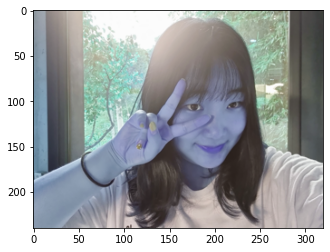

In [2]:
my_image_path = 'aiffel/camera_sticker/images/image_sy.png'
img_bgr = cv2.imread(my_image_path) # OpenCV로 이미지 불러오기
img_show = img_bgr.copy() # 출력용 이미지 따로 보관
plt.imshow(img_bgr) # 이미지 출력을 위해 출력할 이미지 올리기
plt.show()

- 푸른빛이 도는 것은 opencv의 특징 때문이다. 다른 이미지 라이브러리는 RGB순임에 반해 opencv는 BGR을 사용해서 붉은색과 푸른색이 바뀌어 출력된다.

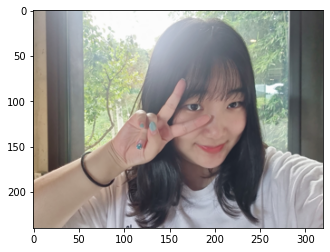

In [3]:
# 색깔 보정하기
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

[OpenCV](https://opencv-python.readthedocs.io/en/latest/doc/01.imageStart/imageStart.html) : cv2.imread(), cv2.imshow(), cv2.imwrite()

## 7-3. 얼굴 검출 face detection

In [4]:
# dlib의 hog detector 선언
detector_hog = dlib.get_frontal_face_detector()

In [5]:
# detector_hog를 이용해 얼굴의 bounding box를 추출
dlib_rects = detector_hog(img_rgb, 1) # (image, num of image pyramid)

[image pyramid](https://opencv-python.readthedocs.io/en/latest/doc/14.imagePyramid/imagePyramid.html) : 이미지를 upsampling(데이터의 크기를 키우는 것) 방법을 통해 크기를 키우는 것

rectangles[[(155, 76) (245, 166)]]


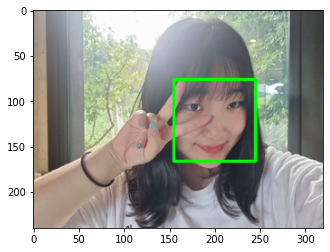

In [6]:
# 찾은 얼굴 영역 박스 리스트(얼굴 crop하기)
print(dlib_rects)

# 찾은 얼굴 영역의 좌표
for dlib_rect in dlib_rects:
    l = dlib_rect.left() # 왼쪽
    t = dlib_rect.top() # 위쪽
    r = dlib_rect.right() # 오른쪽
    b = dlib_rect.bottom() # 아래쪽
    
    # 시작점의 좌표와 종료점 좌표를 직각 사각형으로 그리기
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
    
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

[cv2.rectangle](https://copycoding.tistory.com/146)  
[dlib.rectangles 객체](http://dlib.net/python/index.html#dlib.rectangles)

## 7-4. 얼굴 랜드마크 face landmark
object keypoint estimation 중 top-down 방식 사용하여 bounding box를 찾고 box 내부의 keypoint를 예측한다.

![데이터 다운로드](https://user-images.githubusercontent.com/116326867/204445972-67843855-121c-4967-9b7b-6780c220d589.png)

Dlib의 제공되는 모델을 사용하기 위해 공개되어 있는 weight file을 다운로드. bz2 압축파일 형태로 제공되어 압축을 풀어준 후 사용한다.

In [7]:
# 저장한 landmark 모델 불러오기
model_path = 'aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
# shape_predictor : 모델을 불러오는 함수
# landmark_predictor : RGB이미지와 dlib.rectangle를 입력 받고 dlib.full_object_detection를 반환
# dlib.rectangle: 내부를 예측하는 박스
# dlib.full_object_detection: 각 구성 요소의 위치와, 이미지 상의 객체의 위치를 나타냄

In [8]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark 찾아내기 - face landmark 좌표 저장
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect) # 모든 landmark의 위치정보를 points변수에 저장
    list_points = list(map(lambda p: (p.x, p.y), points.parts())) # landmark 위치정보를 (x,y)형태로 변환 후 list_points에 리스트로 저장
    list_landmarks.append(list_points)
    
print(len(list_landmarks[0]))
# part() : 개별 위치에 접근할 수 있는 함수

68


- list_landmark에 68개의 랜드마크가 얼굴 개수만큼 저장된다. 얼굴이 n개이면 n개의 원소를 갖는다.
- 각 원소는 68개의 랜드마크 위치가 나열된 list. 현재 해당 이미지의 list_landmarks의 원소는 1개이므로 list_landmarks[1]을 호출하면 에러가 난다. 

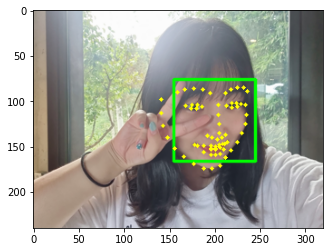

In [9]:
# 랜드마크를 영상에 출력해보기
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0,255, 255), -1)
        
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

[cv2.circle()](https://copycoding.tistory.com/147) : OpenCV의 원을 그리는 함수
-> img_show 이미지 위 각각의 point에 크기가 2이고 (0,255,255) 노란색으로 (-1)내부가 채워진 원 그리기(마지막 인수가 자연수라면 그만큼의 두께의 선으로 원이 그려진다.)
- 각 부위 index

![각 부위 index](https://user-images.githubusercontent.com/116326867/204451726-3ccda6ec-1a73-4c45-852c-70afbcd696c1.png)

## 7-5. 스티커 적용하기

In [10]:
# 죄표 확인하기
# 얼굴 영역을 저장하고 있는 값과 68개의 랜드마크를 저장하고 있는 값으로 반복문 실행
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print(landmark[27]) # 미간의 index는 27
    x = landmark[27][0] # 이미지에서 미간 부위의 x값
    y = landmark[27][1] - dlib_rect.height()//2 # 이미지에서 미간 부위의 y값 - 얼굴 영역의 세로를 차지하는 픽셀의 수//2
    w = h = dlib_rect.width() # 얼굴 영역의 가로 픽셀의 수
    print(f'(x,y) : ({x},{y})')
    print(f'(w,h) : ({w},{h})')

(204, 104)
(x,y) : (204,59)
(w,h) : (91,91)


- zip() : 두 그룹의 데이터를 서로 엮어주는 파이썬의 내장 함수(dlib_rects와 list_landmarks 데이터를 엮어주기)
- dlib_rects : 얼굴 영역을 저장하고 있는 값 → rectangles[[(155, 76) (245, 166)]]
- list_landmarks : 68개의 랜드마크 값 저장(이목구비 위치(x,y))
- 미간의 중심점 : (204, 104) / 미간 부위 x,y값 = 204,59 / 얼굴영역 가로,세로를 차지하는 픽셀 수 = 91,91

In [11]:
# 왕관 스티커 이미지 읽어오기 및 resize
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/king.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print(img_sticker.shape)

(91, 91, 3)


In [12]:
# 원본 이미지에 스티커 이미지를 추가하기 위해서 x, y 좌표를 조정. 이미지 시작점은 top-left 좌표이기 때문.
# refined_x, refined_y값에서 왕관 이미지가 시작된다는 의미.
refined_x = x - w // 2 
refined_y = y - h
print(f'(x,y) : ({refined_x},{refined_y})')

(x,y) : (159,-32)


- 음수 발생 = 왕관이 이미지의 범위를 벗어났다는 것. opencv는 ndarray데이터를 사용하는데, ndarray는 음수인덱스에 접근 불가하므로 스티커 이미지를 잘라 줘야 한다.
스티커의 시작점+스티커의 사진의 크기가 원본 이미지의 크기보다 큰 경우(=오른쪽이나 아래쪽으로 넘어가는 경우)도 존재. -> 이미지를 잘라줘야 함.

In [13]:
# 왕관 이미지가 이미지 밖에서 시작하지 않도록 조정
# 좌표 순서가 y,x임에 유의할 것 (y,x,rgb channel)
# -y 크기만큼 스티커를 crop 하고, top 의 x좌표와 y 좌표를 각각의 경우에 맞춰 원본 이미지의 경계 값으로 수정하기
# 음수값 만큼 왕관 이미지 자르기
if refined_x < 0:
    img_sticker = img_sticker[:, -refiend_x:]
    refined_x = 0
    
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0
    #(91, 91, 3)에서 (90, 91, 3)이 됨 (91개 중에서 1개가 잘려나감)

print(f'(x,y) : ({refined_x},{refined_y})')
# -y 크기만큼 스티커 crop. x좌표와 y 좌표를 각각의 경우에 맞춰 원본 이미지의 경계 값으로 수정.

(x,y) : (159,0)


In [14]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
# sticker_area : 원본이미지에서 스티커를 적용할 위치를 crop한 이미지
# 좌표 순서가 y,x임에 유의할 것 (y,x,rgb channel)
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
# 왕관 이미지에서 사용할 부분은 0이 아닌 색이 있는 부분을 사용합니다.
# 왕관 이미지에서 0이 나오는 부분은 흰색이라는 뜻, 즉 이미지가 없다는 소리임.
# 현재 왕관 이미지에서는 왕관과 받침대 밑의 ------ 부분이 됨
# 그렇기 때문에 0인 부분(이미지가 없는 부분)은 제외하고 적용
# sticker_area는 원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지입니다.
# 즉, 왕관 이미지에서 왕관 이미지가 없는 부분(왕관과 받침대 밑의 ------ 부분)은 원본 이미지에서 미리 잘라놓은 sticker_area(스티커 적용할 부분 만큼 원본 이미지에서 자른 이미지)를 적용하고,
# 나머지 부분은 스티커로 채워주면 됨
# np.where는 조건에 해당하는 인덱스만 찾아서 값을 적용하는 방법이다.
# 아래 코드에서는 img_sticker가 0일 경우(왕관 이미지에서 왕관 부분 제외한 나머지 이미지)에는 sticker_area(원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지)를 적용하고,
# 나머지 부분은 img_sticker(왕관 이미지)를 적용한다.

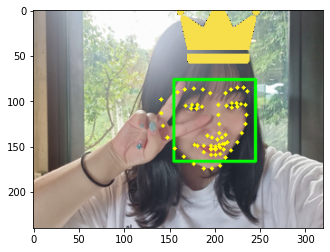

In [15]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()
# 왕관 이미지를 적용한 이미지를 보여준다.
# 얼굴 영역(7-3)과 랜드마크(7-4)를 미리 적용해놓은 img_show에 왕관 이미지를 덧붙인 이미지가 나오게 된다.

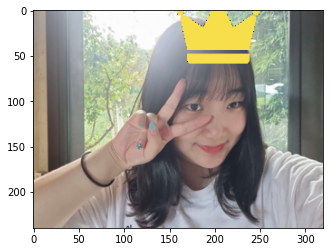

In [16]:
# 왕관 이미지
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
# img_bgr은 7-2에서 rgb로만 적용해놓은 원본 이미지이다. 
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
# img_bgr은 7-2에서 rgb로만 적용해놓은 원본 이미지
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)) # rgb만 적용해놓은 원본 이미지에 왕관 이미지를 덮어 씌운 이미지가 나오게 된다.
plt.show()